# 숫자 멀티 라벨 분류기 실습

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

# CSV 파일 확인

In [4]:
data_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/2/data/annotations.csv')
data_df

,filename,filepath,classes
0,image_26645.jpg,images/image_26645.jpg,"[3, 5]"
1,image_24828.jpg,images/image_24828.jpg,"[1, 3]"
2,image_12280.jpg,images/image_12280.jpg,"[4, 0]"
3,image_7446.jpg,images/image_7446.jpg,"[9, 5]"
4,image_15460.jpg,images/image_15460.jpg,[2]
...,...,...,...
1995,image_22670.jpg,images/image_22670.jpg,"[6, 1]"
1996,image_4461.jpg,images/image_4461.jpg,"[8, 2]"
1997,image_29189.jpg,images/image_29189.jpg,"[2, 6]"
1998,image_15688.jpg,images/image_15688.jpg,"[4, 1]"


In [5]:
data_df['filepath'].tolist()

['images/image_26645.jpg',
 'images/image_24828.jpg',
 'images/image_12280.jpg',
 'images/image_7446.jpg',
 'images/image_15460.jpg',
 'images/image_11895.jpg',
 'images/image_28662.jpg',
 'images/image_24167.jpg',
 'images/image_29695.jpg',
 'images/image_4030.jpg',
 'images/image_21897.jpg',
 'images/image_23495.jpg',
 'images/image_6892.jpg',
 'images/image_22810.jpg',
 'images/image_18577.jpg',
 'images/image_28824.jpg',
 'images/image_5746.jpg',
 'images/image_11403.jpg',
 'images/image_25505.jpg',
 'images/image_29332.jpg',
 'images/image_7815.jpg',
 'images/image_22671.jpg',
 'images/image_11211.jpg',
 'images/image_14183.jpg',
 'images/image_9899.jpg',
 'images/image_24085.jpg',
 'images/image_4207.jpg',
 'images/image_26950.jpg',
 'images/image_2409.jpg',
 'images/image_19514.jpg',
 'images/image_17304.jpg',
 'images/image_17794.jpg',
 'images/image_437.jpg',
 'images/image_6498.jpg',
 'images/image_18468.jpg',
 'images/image_8550.jpg',
 'images/image_7914.jpg',
 'images/image

In [6]:
tmp = data_df.iloc[4,2]
tmp = tmp.replace('[', '')
tmp = tmp.replace(']', '')
tmp = tmp.split(',')
tmp = [int(x) for x in tmp]
tmp

[2]

# CustomDataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, data_df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms
        self.classes = classes

        data_num = data_df.shape[0]
        img_list = data_df['filepath'].tolist()
        cls_list = data_df['classes'].tolist()
        
        for i in range(data_num):
            img = os.path.join(root_dir, img_list[i])
            cls = cls_list[i]
            cls = cls.replace('[', '')
            cls = cls.replace(']', '')
            cls = cls.split(',')
            cls = [int(x) for x in cls]

            self.data.append((img, cls))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        cls = self.data[idx][1]
        cls = torch.nn.functional.one_hot(torch.tensor(cls), len(self.classes)).sum(dim=0).to(torch.float) # sum을 안 하면 각각에 대해서 one-hot이 되어있다. sum을 통해 하나의 리스트로 만들어준다.
        
        return img, cls

In [8]:
transforms = T.Compose([
    T.Resize((112, 224)),
    T.ToTensor()
])

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/2/data', classes, data_df, transforms)

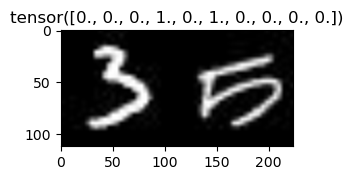

In [9]:
plt.figure(figsize=(3, 3))
plt.imshow(total_dataset[0][0].permute(1, 2, 0))
plt.title(total_dataset[0][1])
plt.show()

In [10]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

# train

In [35]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_preds = []
    total_labels = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    train_loss = train_loss / len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='micro')

    return model, train_loss, train_f1

def evalutation(model, valid_dataloader, valid_dataset, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}]')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='micro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    train_loss_list = []
    train_f1_list = []
    valid_loss_list = []
    valid_f1_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, train_dataset, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evalutation(model, valid_dataloader, valid_dataset, criterion, threshold, epoch, num_epochs)

        train_loss_list.append(train_loss)
        train_f1_list.append(train_f1)
        valid_loss_list.append(valid_loss)
        valid_f1_list.append(valid_f1)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list

# model

In [31]:
model = models.resnet50(pretrained=True)
model

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
for param in model.parameters():
    param.requires_grad = False

In [33]:
model.fc = torch.nn.Linear(2048, 10)

for param in model.fc.parameters():
    param.requires_grad = True

# 학습

In [36]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list, train_f1_list, valid_loss_list, valid_f1_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 0.5, 10)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.3155532395467162, Train F1: 0.5377630121816169, Valid Loss: 0.3079126089811325, Valid F1: 0.5504273504273505


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.27999727204442026, Train F1: 0.6315362788812322, Valid Loss: 0.2849462151527405, Valid F1: 0.6126418152350082


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2556605294346809, Train F1: 0.6774951076320939, Valid Loss: 0.2772809013724327, Valid F1: 0.6226993865030676


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2396847316995263, Train F1: 0.7156244023713904, Valid Loss: 0.26195646077394485, Valid F1: 0.6595092024539877


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.22963452152907848, Train F1: 0.727100681302044, Valid Loss: 0.25882923156023024, Valid F1: 0.65


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.22655828166753053, Train F1: 0.730295106462458, Valid Loss: 0.25720274448394775, Valid F1: 0.6814159292035399


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.22002216130495073, Train F1: 0.7441089837997054, Valid Loss: 0.2504835486412048, Valid F1: 0.6827067669172932


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.20978224966675044, Train F1: 0.7575040931417135, Valid Loss: 0.26575171649456025, Valid F1: 0.7073509015256588


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.20756789725273847, Train F1: 0.7556453093445935, Valid Loss: 0.24495661109685898, Valid F1: 0.6911764705882353


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.19614345543086528, Train F1: 0.7773941486461928, Valid Loss: 0.24415854513645172, Valid F1: 0.7001477104874446


# test

In [37]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
f1_score(total_preds, total_labels, average='micro')

0.7119645494830132

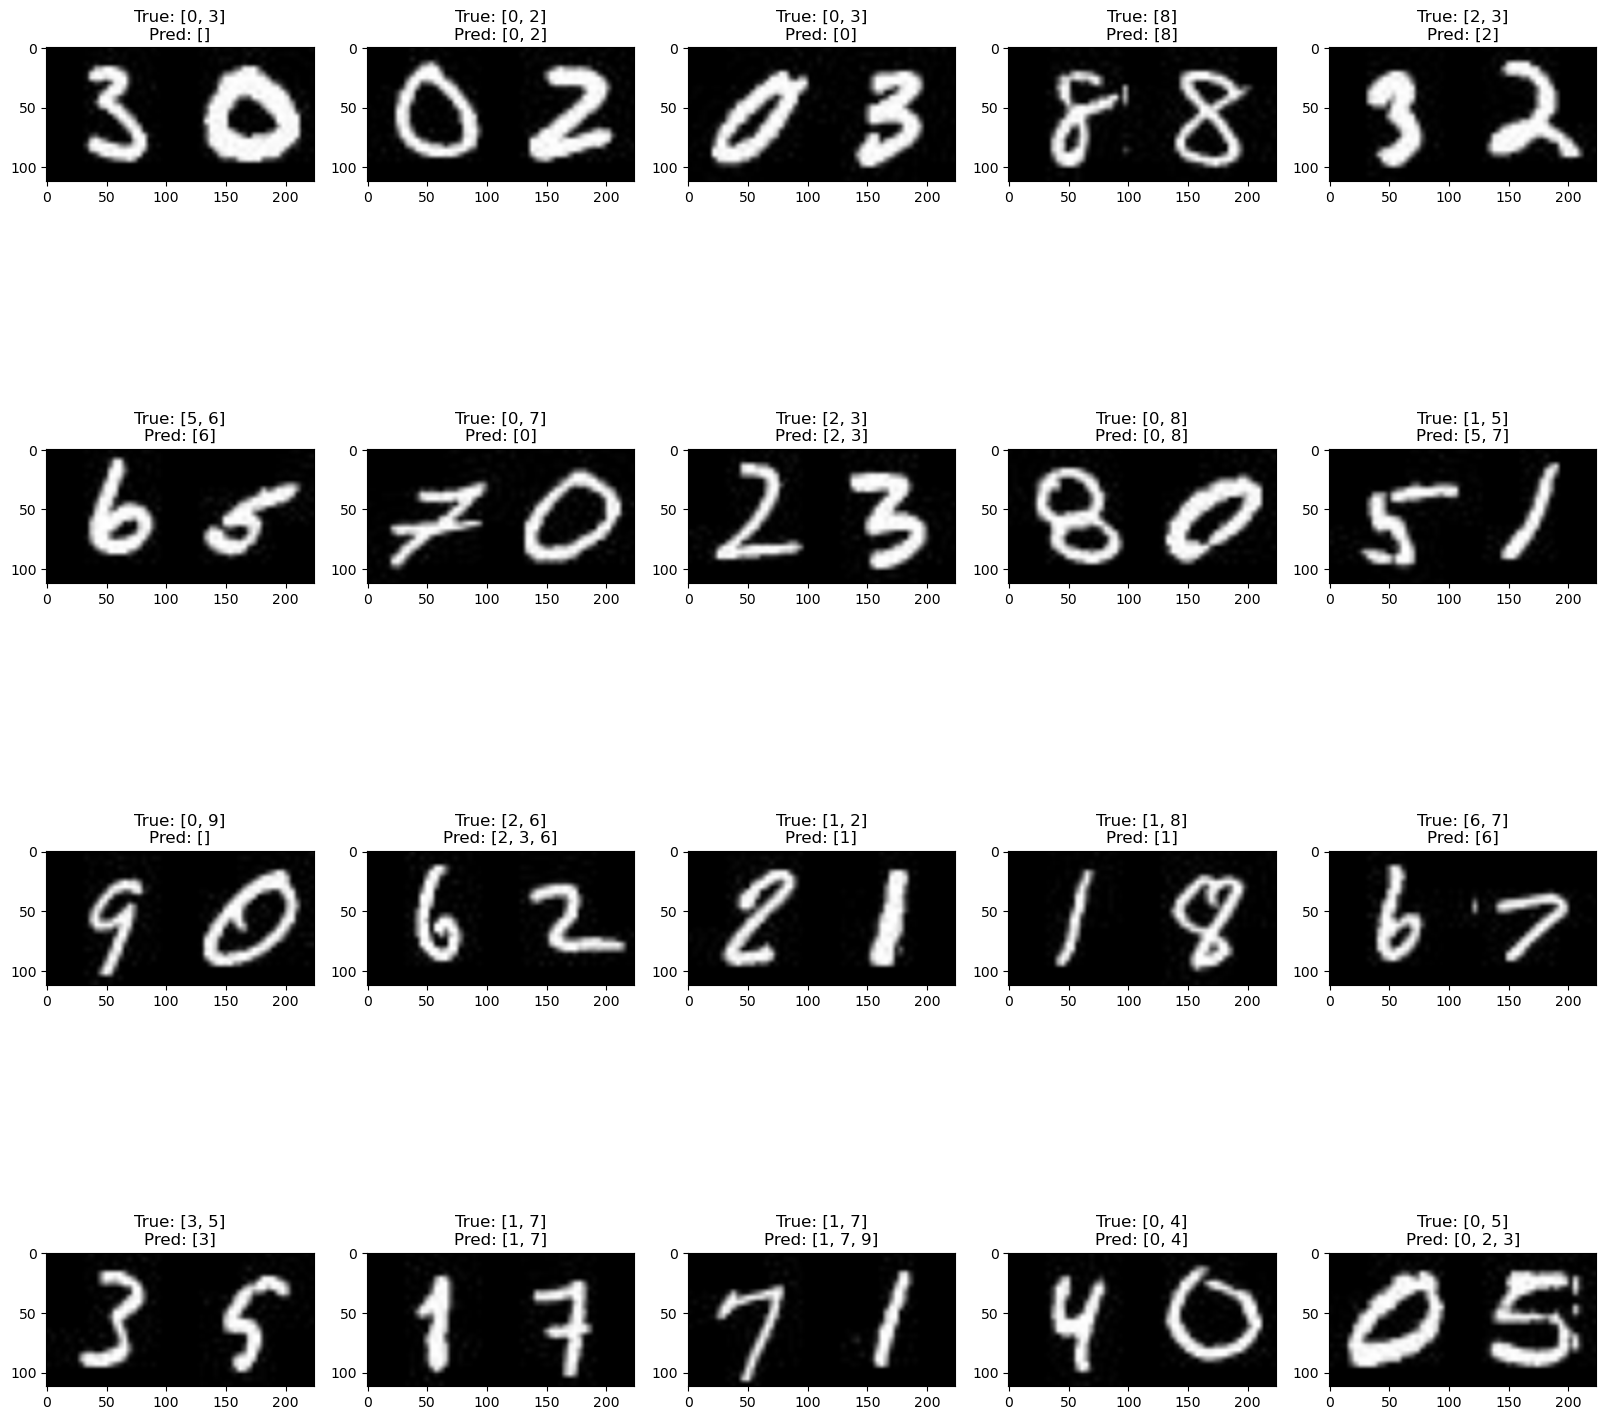

In [48]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    img = plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    real = []
    preds = []

    for j in range(10):
        if total_labels[i][j] == 1:
            real.append(j)

        if total_preds[i][j] == 1:
            preds.append(j)

    plt.title(f'True: {real}\nPred: {preds}')